In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

filepath_processed = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Processed CBS data/'
filepath_raw = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Raw CBS data/'
filepath_other = 'C:/Users/Dirk/Google Drive/Dirk/TU/Afstuderen/Afstuderen/Thesis/3. Formalisation/Raw data other/'

In [2]:
buurten = pd.read_csv(filepath_raw + 'postcode_huisnummer_buurten.csv',delimiter = ';')
wijk = pd.read_csv(filepath_raw + 'wijk2019.csv', delimiter = ';')
buurt = pd.read_csv(filepath_raw + 'buurt2019.csv', delimiter = ';')
wijk_dict = wijk.astype(str).set_index('Wijkcode2019').to_dict()['Wijknaam_2019K_NAAM']
buurt.Buurtcode_2019 = buurt.Buurtcode_2019.astype(str)
buurt_dict = buurt.set_index('Buurtcode_2019').to_dict()['Buurtnaam_2019']

buurten[['Buurt2019']]= buurten[['Buurt2019']].astype(str)
buurten[['Wijk2019']] = buurten[['Wijk2019']].astype(str)
buurten['buurt_naam'] = buurten['Buurt2019'].map(buurt_dict)
buurten['wijk_naam'] = buurten['Wijk2019'].map(wijk_dict)
buurten = buurten.drop(['Buurt2019','Wijk2019','Gemeente2019'], axis = 1).rename(columns = {'PC6':'postcode','Huisnummer':'huisnummer'})

In [3]:
kwb_2019 = pd.read_excel(filepath_raw + 'kwb-2019.xls')
kwb_2018 = pd.read_excel(filepath_raw + 'kwb-2018.xls')
kwb_2017 = pd.read_excel(filepath_raw + 'kwb-2017.xls')

In [4]:
WKO = pd.read_excel(filepath_other + 'Warmteatlas WKO potentie.xlsx', 
                    usecols = ['buurtcode', "Centroid in WKO-contour?", "Potentie WKO per buurt (GJ)",
                            "Potentie bodemlussen per buurt (GJ)" ])


In [5]:
total = pd.read_csv(filepath_processed + 'total_characteristics.csv',index_col = [0,1])
total = total['total']

In [6]:
kwb_2019_selected = kwb_2019[['gm_naam','regio','gwb_code_10', 'recs','g_woz', 'p_koopw', 'p_wcorpw', 'p_ov_hw','a_opp_ha','a_lan_ha', 'a_wat_ha' ]].where(kwb_2019['recs']=='Buurt').drop('recs', axis = 1).dropna(how = 'all').rename(columns = {'regio' : 'buurt_naam','gm_naam': 'gemeente'})
kwb_2018_selected = kwb_2018[['gm_naam','regio','recs', 'g_ink_pi', 'p_hh_li','p_hh_hi' ]].where(kwb_2018['recs']=='Buurt').drop('recs', axis = 1).dropna(how = 'all').rename(columns = {'regio' : 'buurt_naam','gm_naam': 'gemeente'})
kwb_2017_selected = kwb_2017[['gm_naam','regio','recs','p_stadsv','g_ink_pi' ]].where(kwb_2017['recs']=='Buurt').drop('recs', axis = 1).dropna(how = 'all').rename(columns = {'regio' : 'buurt_naam','gm_naam': 'gemeente'})

In [7]:
#Needed to prevent errors in Vensim and Netlogo, which don't deal well with non-latins
kwb_2017_selected.gemeente = kwb_2017_selected.gemeente.replace({"Nuenen, Gerwen en Nederwetten": "Nuenen Gerwen en Nederwetten", "Noardeast-Fryslân": "Noardeast-Fryslan" , "Súdwest-Fryslân":"Sudwest-Fryslan" })
kwb_2018_selected.gemeente = kwb_2018_selected.gemeente.replace({"Nuenen, Gerwen en Nederwetten": "Nuenen Gerwen en Nederwetten", "Noardeast-Fryslân": "Noardeast-Fryslan" , "Súdwest-Fryslân":"Sudwest-Fryslan" })
kwb_2019_selected.gemeente = kwb_2019_selected.gemeente.replace({"Nuenen, Gerwen en Nederwetten": "Nuenen Gerwen en Nederwetten", "Noardeast-Fryslân": "Noardeast-Fryslan" , "Súdwest-Fryslân":"Sudwest-Fryslan" })


In [8]:
df = total.to_frame().merge(kwb_2019_selected, on = ['gemeente','buurt_naam'], how = 'inner').set_index(['gemeente', 'buurt_naam'])
df = df.merge(kwb_2018_selected, on = ['gemeente','buurt_naam'], how = 'left').merge(kwb_2017_selected, on = ['gemeente','buurt_naam'], how = 'left')
df = df.merge(WKO, left_on = "gwb_code_10", right_on = 'buurtcode', how = 'left' ).set_index(['gemeente', 'buurt_naam'])
df = df.drop('buurtcode', axis = 1)

In [9]:
df['P-WKO'] = df['Potentie WKO per buurt (GJ)'] * 277.78 / 1650 # IN MW
df['P-GHP'] = df['Potentie bodemlussen per buurt (GJ)'] * 277.78 / 1650 
df['P-TESW'] = df['a_wat_ha'] / df['a_opp_ha'] * df['P-WKO']  

In [10]:
buurten_gamma = pd.read_csv(filepath_processed + 'total_gamma.csv', skiprows = 2)
df = df.reset_index().drop_duplicates().merge(buurten_gamma[['gemeente','buurt_naam']].drop_duplicates(),how = 'inner').drop_duplicates(subset = ['gemeente','buurt_naam']).merge(buurten_gamma[['gemeente','buurt_naam']],how = 'outer')

In [11]:
# Take 2018 income, append with 2017 income
for i in [ 'g_ink_pi_x' , 'g_ink_pi_y']: #just average income
    df[i] = pd.to_numeric(df[i].astype(str).str.replace(',','.'), errors = 'coerce')
    df['g_ink_pi'] = pd.merge(df.g_ink_pi_x , df.g_ink_pi_y.where(df.g_ink_pi_x.isnull()), left_index = True, right_index= True).sum(axis = 1).replace({0:np.nan})
df = df.drop(['g_ink_pi_y','g_ink_pi_x'], axis = 1)

In [12]:


for i in df.columns.drop(['p_stadsv','gwb_code_10','total'])[2:]: #exclude cityheating
    df[i] = pd.to_numeric(df[i].astype(str).str.replace(',','.'), errors = 'coerce')

#Separate operation for cityheating: missing data -> no cityheating
df['p_stadsv'] = pd.to_numeric(df['p_stadsv'].astype(str).str.replace(',','.'), errors = 'coerce').fillna(0)

#fill with mean from municiaplities
df = df.set_index(['gemeente','buurt_naam']).fillna(df.set_index('gemeente').mean(level = 'gemeente'))

for i in df.columns.drop(['p_stadsv','gwb_code_10','total']): # fill remaining NaNs with nationwide means
       df[i] = df[i].fillna(df[i].mean())

In [13]:
df = df.rename(columns = {'gwb_code_10': 'BU_CODE'}).reset_index()

In [14]:
# pipe length estimates from PBL's VESTA
pipe_length = pd.read_csv(filepath_other + 'buislengte_VESTA.csv',delimiter = ';')

In [15]:
df = df.merge(pipe_length, on = 'BU_CODE', how = 'left').drop(['BU_CODE','Panden'],axis = 1)#.set_index(['gemeente','buurt_naam'])


In [16]:
xycor = pd.read_csv(filepath_processed + 'relative_xycor_buurten.csv')

In [17]:
df = df.merge(xycor, on = ['gemeente','buurt_naam']).set_index(['gemeente','buurt_naam'])

In [18]:
df['total'] = df.total.fillna(0)
df = df.sort_index()

In [19]:
df.to_csv(filepath_processed + 'total_kwb.csv')

In [20]:
df.Aansluit_lengte_m.replace({0:np.nan}, inplace = True)

In [21]:
#df.where(df.Hoofdleiding_lengte_m.isnull()).dropna(how = 'all').merge(pipe_length, on = 'BU_CODE', how = 'left')

In [22]:
((df.a_lan_ha / df.total) / (df.Aansluit_lengte_m)).median()

3.396457769727818e-05

In [23]:
import matplotlib.pyplot as plt


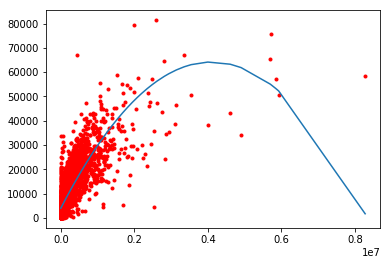

3995.5140978743157 0.029361081403745222 -3.581295317859401e-09


In [24]:
x = (df.total * df.a_opp_ha).where(df.Aansluit_lengte_m.notnull()).dropna(how = 'all').values
y = df.Aansluit_lengte_m.dropna().values
a, b, c  = np.polyfit(x, y, 2)

plt.plot((x), (y), 'r.')
x.sort()
plt.plot(x,(a * x**2 + b*x + c ))

plt.show()
print(c, b, a)
aansluit_lengte_vars = a, b , c

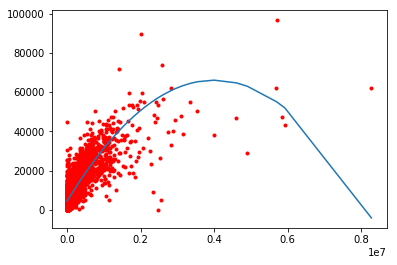

-3.846198114207384e-09 0.03079965122722052 4452.267853042382


In [25]:
x = (df.total*df.a_opp_ha).where(df.Hoofdleiding_lengte_m.notnull()).dropna(how = 'all').values
y = df.Hoofdleiding_lengte_m.dropna().values
a, b, c  = np.polyfit(x, y, 2)

plt.plot((x), (y), 'r.')
x.sort()
plt.plot(x,(a * x**2 + b*x + c ))


plt.show()
print(a,b,c)
hoofdleiding_vars = a,b,c 

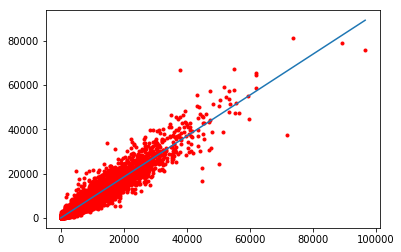

0.9248278209175209 -44.82734415090401


In [26]:
x = (df.Hoofdleiding_lengte_m).where(df.Aansluit_lengte_m.notnull()).dropna(how = 'all').values
y = df.Aansluit_lengte_m.dropna().values
a, b  = np.polyfit(x, y, 1)

plt.plot((x), (y), 'r.')
x.sort()
#plt.plot(x,(a * x**2 + b*x + c ))
plt.plot(x,(a*x + b ))

plt.show()
print(a,b)

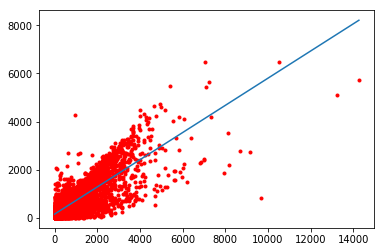

0.5644903060326091 155.86252997809083


In [27]:
x = (df.total).where(df.Aansluitingen.notnull()).dropna(how = 'all').values
y = df.Aansluitingen.dropna().values
a, b  = np.polyfit(x, y, 1)

plt.plot((x), (y), 'r.')
x.sort()
#plt.plot(x,(a * x**2 + b*x + c ))
plt.plot(x,(a*x + b ))

plt.show()
print(a,b)
aansluitingen_vars = a,b 

In [28]:
def aansluit_func(x):
    a, b, c = aansluit_lengte_vars
    return a * x**2 + b*x + c 
def hoofdl_func(x):
    a, b, c = hoofdleiding_vars
    return a * x**2 + b*x + c 
def aansl_func(x):
    a, b = aansluitingen_vars
    return a * x + b 

In [29]:
df ['aansluit_est'] = ((df.a_opp_ha * df.total)).map(aansluit_func)
df ['hoofdl_est'] = ((df.a_opp_ha * df.total)).map(hoofdl_func)
df ['aansluitingen_est'] = df.total.map(aansl_func)

In [30]:
df.Aansluitingen.fillna(df.aansluitingen_est.where(df.Aansluitingen.isnull()).dropna(),inplace = True)
df.Hoofdleiding_lengte_m.fillna(df.hoofdl_est.where(df.Hoofdleiding_lengte_m.isnull()).dropna(),inplace = True)
df.Aansluit_lengte_m.fillna(df.aansluit_est.where(df.Aansluit_lengte_m.isnull()).dropna(),inplace = True)

In [31]:
#get rid of estimation columns 
df = df[df.columns[:-3]]

In [32]:
df.to_csv(filepath_processed + 'total_kwb.csv')